In [9]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

Populating the interactive namespace from numpy and matplotlib


In [35]:
def ABC(priorSampler, likelihoodSimulator, summaryStatistics, epsilon, data, n): # epsilon is the number
    # data is a numpy.array (format), each element is one observation 
    # priorSampler and likelihoodSimulator return numpy.arrays, each element is a random variable
    # summaryStatistics returns a 1-dim array
    
    # priorSampler - a function taking one argument: n - the desired length of the sample, it returns an np.array
    # likelihoodSimulator - a function taking two argument: the desired number of observations and the current parameter, it returns an np.array 
    # summaryStatistics - a function taking one argument - data, returns a 1-dim array
    # epsilon - currently a number, not percentage,
    # data - an array
    # n - number of simulations (not the number of accepted samples)
    
    prior_sample = priorSampler(n)
    stat = summaryStatistics(data)
    theta_generated = []
    accepted = []
    output_list = []
    
    for i in range(n):
        # data is currently an array of shape (data_len,)
        simulated_data = likelihoodSimulator(shape(data)[0], prior_sample[i])
        
        temporary_stat = summaryStatistics(simulated_data)
        # in the line below we are comparing sum of squares of the elements of temporary_stat - stat
        if np.sum(np.square(np.subtract(temporary_stat, stat))) < epsilon*epsilon: # check here!
            accept = 1
            print("ciao")
        else: accept = 0
            
        output_dict = {'accept': accept, 'z':simulated_data, 'theta': prior_sample[i]} # added theta
        # seems more reasonable to add the theta at the end of function ...
        output_list.append(output_dict)
    
    df = pd.DataFrame(output_list)
    return df

In [134]:
def ABC_sample(priorSampler, likelihoodSimulator, summaryStatistics, epsilon, data, n): # epsilon is the number
    # data is a numpy.array (format), each element is one observation 
    # priorSampler and likelihoodSimulator return numpy.arrays, each element is a random variable
    # summaryStatistics returns a 1-dim array
    
    # priorSampler - a function taking one argument: n - the desired length of the sample, it returns an np.array
    # likelihoodSimulator - a function taking two argument: the desired number of observations and the current parameter, it returns an np.array 
    # summaryStatistics - a function taking one argument - data, returns a 1-dim array
    # epsilon - currently a number, not percentage,
    # data - an array
    # n - number of accepted samples (NOT number of iterations)
    
    stat = summaryStatistics(data)
    theta_generated = []
    accepted = []
    output_list = []
    i = 0
    niter = 0
    while True:
        niter = niter+1
        # simulate prior
        simulated_prior = priorSampler(1)
        # data is currently an array of shape (data_len,)
        simulated_data = likelihoodSimulator(shape(data)[0], simulated_prior[0])
        
        temporary_stat = summaryStatistics(simulated_data)
        # in the line below we are comparing sum of squares of the elements of temporary_stat - stat
        if np.sum(np.square(np.subtract(temporary_stat, stat))) < epsilon*epsilon: # check here!
            accept = 1
            output_dict = {'accept': accept, 'z':simulated_data, 'theta': simulated_prior[0]} # added theta
            # seems more reasonable to add the theta at the end of function ...
            output_list.append(output_dict)
            i = i+1
        else: accept = 0         
        
        if i==n:
            break
    
    df = pd.DataFrame(output_list)
    return (df, niter)

In [73]:
def weighted_variance(values, weights):
    average = numpy.average(values, weights=weights)
    variance = numpy.average((values-average)**2, weights=weights)
    variance = variance*len(values)/(len(values)-1)
    return variance

In [137]:
def ABC_PMC(priorFunction, priorSampler, likelihoodSimulator, summaryStatistics, epsilon_array, data, n): 
    # epsilon_array is a numpy.array, it should be a decreasing sequence of tolerance values
    # data is a numpy.array (format), each element is one observation 
    # priorSampler and likelihoodSimulator return numpy.arrays, each element is a random variable
    # summaryStatistics returns a 1-dim array
    
    # priorFunction - a function taking one argument and returns the value of the pdf of the prior in that argument
    # priorSampler - a function taking one argument: n - the desired length of the sample, it returns an np.array
    # likelihoodSimulator - a function taking two argument: the desired number of observations and the current parameter, it returns an np.array 
    # summaryStatistics - a function taking one argument - data, returns a 1-dim array
    # epsilon - currently a number, not percentage,
    # data - an array
    # n - number of accepted samples (NOT number of iterations! WHATCH OUT)
    
    #Run basic ABC using the first tolerance level
    temp = ABC_sample(priorSampler, likelihoodSimulator, summaryStatistics, epsilon_array[0], data , n)
    df = temp[0]
    niter = temp[1] #Number of iterations required for the initial step
    weight_old = np.ones(n)*(1/n) #assign "basic" weights to the sampled parameters
    theta_old = df.theta
    sigma_squared = 2*weighted_variance(df.theta,weight_old) #Compute a weighted empirical variance of theta. Used as variance in the Gaussian kernel
    
    stat = summaryStatistics(data) #compute statistics of original data
    
    for t in range(1,len(epsilon_array)):
        print(t)
        i = 0
        theta_accepted = []
        weight = []
        sigma = sqrt(sigma_squared)
        while True:
            niter = niter+1
            theta_star = np.random.choice(theta_old, size = 1, p=weight_old) #get one of the previous theta obtained at random (weighted)
            simulated_prior = np.random.normal(loc = theta_star, scale = sigma, size = 1) #perturbate the choice
            simulated_data = likelihoodSimulator(shape(data)[0], simulated_prior[0]) #simulate data
            temporary_stat = summaryStatistics(simulated_data) #get statistics of simulated data
            if np.sum(np.square(np.subtract(temporary_stat, stat))) < epsilon_array[t]*epsilon_array[t]:
                #Accept!
                theta_accepted.append(simulated_prior[0])
                #Compute weight
                den = 0
                for j in range(0,n):
                    aux = (1/sigma)*(simulated_prior[0]-theta_old[j])
                    den = den + weight_old[j]*(1/sigma)*(1/sqrt(2*math.pi))*exp(-(aux)**2/2)
                weight.append(priorFunction(simulated_prior[0])/den)
                #End compute weight
                i = i+1
            if i==n:
                break
        
        weight = weight/np.sum(weight) #normalize weight so that the sum is 1
        sigma_squared = 2*weighted_variance(theta_accepted,weight) #compute sigma given the new weights
        print(sigma_squared)
        weight_old = weight #save weight for next step
        theta_old = theta_accepted
    return(theta_accepted, niter)

In [101]:
######
# set up for the normal ABC example
######

prior_mean = -3.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorFunction(x):
    return ss.norm.pdf(x=x,loc=prior_mean, scale=prior_sd)

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=100)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print (post_mean, "is posterior mean")
print (post_sd, "is posterior std dev")

-0.066216664926 is posterior mean
0.0999444906979 is posterior std dev
0.132980760134


In [139]:
#Comparison on number of iterations
size_sample = 100
df1 = ABC_sample(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, 0.05, data , size_sample)
df2 = ABC_PMC(NormalPriorFunction,NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, [1,0.5,0.2,0.1,0.05], data , size_sample)

print("Number of iterations ABC: ",df1[1])
print("Number of iterations ABC-PMC: ",df2[1])

1
0.160672065212
2
0.0489684081928
3
0.0319693741854
4
0.019983156465
Number of iterations ABC:  11377
Number of iterations ABC-PMC:  2112


In [138]:
df2 = ABC_PMC(NormalPriorFunction,NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, [1,0.5,0.2,0.1,0.05], data , 100)
print(df2)

1
0.17181600291
2
0.0462152375088
3
0.0225037779256
4
0.0217784803662
([-0.018605825992238714, -0.2180765476452268, -0.20113142153896391, -0.038751377356504038, 0.039069457275242692, -0.1268689429460354, -0.13649013595925635, -0.025369518996863433, -0.12469572962318268, 0.0065063050380059599, -0.027647538783498085, 0.07484331427666352, 0.047608813385298501, -0.086872102668026197, -0.11665523543184715, 0.050434515103590788, 0.043474835441794521, -0.19193968095287595, -0.10049768550684501, 0.0039580599939859767, -0.011026157068740432, -0.0424816731312741, 0.19236194713273227, -0.16253602318916774, -0.1499197693035387, -0.19309611296492984, -0.030615587408933942, -0.078850281652225226, -0.18897921950529784, -0.11121160879049551, 0.10096061012262088, -0.18167042482009424, -0.06463902770974389, -0.11300754065618313, 0.01957726417373417, -0.023621377053405064, -0.16590932220593455, 0.090331147172290738, 0.031371744136244405, -0.12373777178633814, -0.272218985575235, -0.19289372593319429, 0.0

In [70]:
df = ABC_sample(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, 0.2, data , 100)
print(np.sum(df.accept))
print(df)

100
    accept     theta                                                  z
0        1 -0.183514  [0.193868361514, 0.300044699998, -1.0472019484...
1        1 -0.256781  [0.691436394817, 0.0399424087506, 0.4942470936...
2        1 -0.236263  [-0.236601149596, -0.263974616076, 0.707472575...
3        1 -0.237503  [-0.237740785278, 1.21611491815, -0.2651348773...
4        1 -0.023184  [0.286033522656, -0.619077936941, 1.1271551339...
5        1 -0.438250  [-0.00985428917287, -0.468163887037, 0.9729039...
6        1  0.032483  [-0.468419824205, 1.03689717184, -0.7720316184...
7        1 -0.072880  [0.457643439942, 0.694437116312, 0.66968027194...
8        1 -0.268695  [-0.557721938065, 0.201468960814, -0.223338178...
9        1 -0.000861  [0.986485229932, -0.21438781808, 0.54076433859...
10       1 -0.183356  [0.175594898757, 0.529484345325, -1.9847858008...
11       1  0.075387  [0.270483719514, -1.35781718653, -1.1900846719...
12       1 -0.076448  [-0.803985917165, -0.207088531849, 0.1

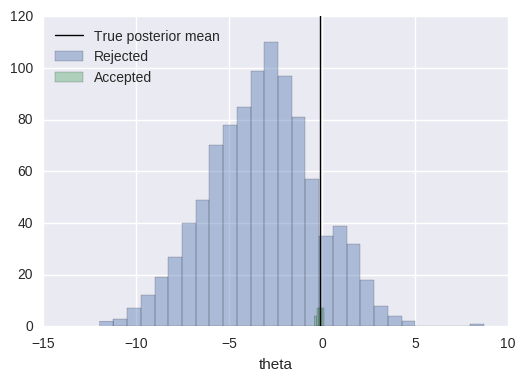

In [26]:
######
# plot the accepted and rejected params
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    sns.distplot(sub_df.theta, ax=ax, kde = False, label=accept_legend_map[accept]) #norm_hist =True,


plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')